In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

palette={"Original": "#80EBC0", "RFA": "#E7274E", 
                     "RBA": '#F6DF83', "Corrected BA": "#197FCD", "Real": '#311162'}


In [2]:
## Generate a semi-realistic random model of order 2, with 12 sites
## with one strong 5 order epistatic interaction
degree = 2
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    if poly.powers_[ii].sum() == 1:
        real_coefficients[ii] = np.random.normal(loc=0., scale=0.2)
    #else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
    #    real_coefficients[ii] = np.random.normal(loc=-0, scale=0.1)#/np.sqrt(counts[ii]))

coef = -1
real_coefficients[-3] = coef
real_coefficients[-5] = coef
real_coefficients[-6] = coef
real_coefficients[-1] = coef
        
real_phenotypes = geno@real_coefficients

# add a small noise
measured_phenotypes = geno@real_coefficients + 0.2 * np.random.normal(size=real_phenotypes.shape)


In [3]:
import scipy.linalg
from sklearn.metrics import r2_score

def BA_inference(measured_phenotypes, degree, L, test_frac=0):
    poly = PolynomialFeatures(degree, interaction_only=True)
    ## select a random 1/5 subset of the coefficients for testing
    test_idx = np.random.choice(len(measured_phenotypes), int(len(measured_phenotypes)*test_frac), replace=False)
    train_idx = [a for a in range(len(measured_phenotypes)) if a not in test_idx]
    geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in train_idx])
    result_opt = scipy.linalg.lstsq(
        geno, measured_phenotypes[train_idx],
        lapack_driver='gelsy')
    res = result_opt[0]
    
    ## measure the r2 on the test and train set
    train_pred = geno @ res
    # Calculating R-squared
    r2_train = r2_score(measured_phenotypes[train_idx], train_pred)

    r2_test = 0
    if test_frac != 0:
        test_geno = poly.transform([[int(a) for a in f'{b:0{L}b}'] for b in test_idx])
        test_pred = test_geno @ res
        r2_test = r2_score(measured_phenotypes[test_idx], test_pred)
    
        
    
    return res, r2_train, r2_test


In [4]:
poly = PolynomialFeatures(1, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
res, _, _ = BA_inference(measured_phenotypes, 1, L, 1/5)

In [5]:
mutations = []
for ii, g in enumerate(geno):
    mutations += ["".join([str(int(a)) for a in g[-3:-1]])]


/tmp/ipykernel_13280/1383909835.py:11: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.scatterplot(data=dfplot, y='Normalized Phenotype', x='BA/RFA model (order 1)', alpha=1,


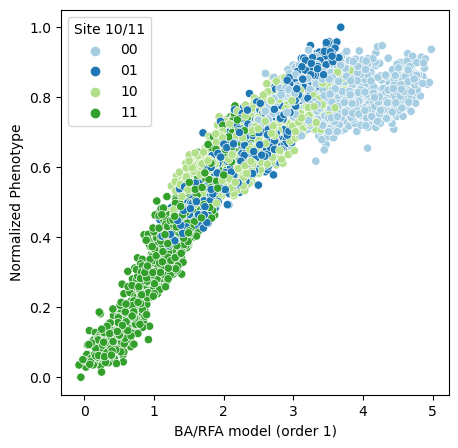

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
normalized_pheno = (measured_phenotypes - measured_phenotypes.min())/(measured_phenotypes.max() - measured_phenotypes.min())
dfplot = pd.DataFrame()
dfplot['Normalized Phenotype'] = normalized_pheno
dfplot['BA/RFA model (order 1)'] = geno@res
dfplot['Site 10/11'] = mutations
dfplot['Site 10/11'] = dfplot['Site 10/11']

sns.scatterplot(data=dfplot, y='Normalized Phenotype', x='BA/RFA model (order 1)', alpha=1, 
                palette=sns.color_palette('Paired'),
                hue='Site 10/11')
plt.ylabel('Normalized Phenotype')
plt.xlabel('BA/RFA model (order 1)')
plt.legend(title='Site 10/11')
plt.savefig('fake_global.png', dpi=600)

In [7]:
import pandas as pd
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize
import scipy.special
from tqdm.notebook import tqdm

dfh1 = pd.read_csv("./bnab-landscapes/CR9114/Kd_meanbin/kd_processed/20210323_h1_all.csv", dtype={'variant':'str'}
        )
dfh9 = pd.read_csv("./bnab-landscapes/CR6261/Kd_meanbin/kd_processed/20210323_h9_all.csv", dtype={'variant':'str'}
        )
# deal with the missing value in dfh9 (add np.nan)
variants = [f'{x:011b}' for x in range(2**11)]
dfh9 = dfh9.set_index('variant').reindex(variants).reset_index()


In [8]:
# load the fluorescence values
concentrations = [-7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5, -12, -14]
concentrations = {str(ii+1): c for ii, c in enumerate(concentrations)}

dfh1['fluo_x'] = dfh1.apply(lambda r: [r[f'c{ii}_x'] for ii in concentrations],axis=1)
dfh1['fluo'] = dfh1.apply(lambda r: [r[f'c{ii}'] for ii in concentrations],axis=1)
dfh1['fluo_y'] = dfh1.apply(lambda r: [r[f'c{ii}'] for ii in concentrations],axis=1)
dfh1['err_fluo_x'] = dfh1.apply(lambda r: [r[f'e{ii}_x'] for ii in concentrations],axis=1)
dfh1['err_fluo'] = dfh1.apply(lambda r: [r[f'e{ii}'] for ii in concentrations],axis=1)
dfh1['err_fluo_y'] = dfh1.apply(lambda r: [r[f'e{ii}'] for ii in concentrations],axis=1)

for ii in concentrations:
    dfh1[f'y{ii}_x'] = dfh1.apply(lambda r: (10**(r[f'c{ii}_x']) - r['B'])/r['A'],axis=1)
    dfh1[f'val{ii}_x'] = dfh1[f'y{ii}_x'].apply(lambda x: np.log10(x/(1-x)))

# remove the intercept:
for ii in concentrations:
    dfh1[f'corr_val{ii}_x'] = dfh1[f'val{ii}_x'] - dfh1[f'val1_x']
    
concentrations = [-7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5, -12, -14]
concentrations = {str(ii+1): c for ii, c in enumerate(concentrations)}

dfh9['fluo_x'] = dfh9.apply(lambda r: [r[f'c{ii}_x'] for ii in concentrations],axis=1)
dfh9['fluo'] = dfh9.apply(lambda r: [r[f'c{ii}'] for ii in concentrations],axis=1)
dfh9['fluo_y'] = dfh9.apply(lambda r: [r[f'c{ii}'] for ii in concentrations],axis=1)

dfh9['err_fluo_x'] = dfh9.apply(lambda r: [r[f'e{ii}_x'] for ii in concentrations],axis=1)
dfh9['err_fluo'] = dfh9.apply(lambda r: [r[f'e{ii}'] for ii in concentrations],axis=1)
dfh9['err_fluo_y'] = dfh9.apply(lambda r: [r[f'e{ii}'] for ii in concentrations],axis=1)


In [9]:
def RB_LS_inference(measured_phenotypes, genotypes, degree, L, test_frac=0):
    """ Reference-based, least-square method (Original) 
        degree: maximum order of the model
        L: number of sites
        test_frac: proportion of sites in the test subset (in a test/train formalism)
    """
    poly = PolynomialFeatures(degree, interaction_only=True)
    ## select a random 1/5 subset of the coefficients for testing
    int_genotypes = [int(a, 2) for a in genotypes]
    idx_test_geno = np.random.choice(range(len(genotypes)),  int(len(measured_phenotypes)*test_frac), replace=False)
    test_geno = [int_genotypes[ii] for ii in idx_test_geno]
    idx_train_geno = [a for a in range(len(genotypes)) if a not in idx_test_geno]
    train_geno = [int_genotypes[ii] for ii in idx_train_geno]
    
    geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in train_geno])
    result_opt = scipy.linalg.lstsq(
        geno, measured_phenotypes[idx_train_geno])
    res = result_opt[0]
    
    ## measure the r2 on the test and train set
    train_pred = geno @ res
    # Calculating R-squared
    r2_train = r2_score(measured_phenotypes[idx_train_geno], train_pred)

    r2_test = 0
    if test_frac != 0:
        poly = PolynomialFeatures(degree, interaction_only=True)
        test_geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in test_geno])
        test_pred = test_geno @ res
        r2_test = r2_score(measured_phenotypes[idx_test_geno], test_pred)
      
    return res, r2_train, r2_test


dfs = {'h1': dfh1, 'h9': dfh9}
for k, L in zip(['h1', 'h9'], [16, 11]):
    order = [''.join([str(a) for a in f'{b:0{L}b}']) for b in range(2**L)]
    dfs[k]['geno'] = pd.Categorical(dfs[k]['variant'], categories=order, ordered=True)
    dfs[k] = dfs[k].sort_values('geno')
    dfs[k]['geno'] = dfs[k]['geno'].astype(str)
    # if missing values, fix them to mean logkd

measured_phenotypes_h1 = dfs['h1'].apply(lambda r: np.nanmean([r['logKd'], r['logKd_x'], r['logKd_y']]), axis=1).to_numpy()
measured_phenotypes_h9 = dfs['h9'].apply(lambda r: np.nanmean([r['logKd'], r['logKd_x'], r['logKd_y']]), axis=1).to_numpy()
measured_phenotypes_h9[np.isnan(measured_phenotypes_h9)] = np.nanmean(measured_phenotypes_h9)

deg = 1
poly = PolynomialFeatures(deg, interaction_only=True)
geno_h1 = poly.fit_transform([[int(a) for a in f'{b:0{16}b}'] for b in range(2**16)])
res_h1, r2, _ = RB_LS_inference(measured_phenotypes_h1,[f'{a:016b}' for a in range(2**16)], 1, 16)

deg = 1
poly = PolynomialFeatures(deg, interaction_only=True)
geno_h9 = poly.fit_transform([[int(a) for a in f'{b:0{11}b}'] for b in range(2**11)])
res_h9, r2, _ = RB_LS_inference(measured_phenotypes_h9,[f'{a:011b}' for a in range(2**11)], 1, 11)


/tmp/ipykernel_13280/98625605.py:44: RuntimeWarning: Mean of empty slice
  measured_phenotypes_h9 = dfs['h9'].apply(lambda r: np.nanmean([r['logKd'], r['logKd_x'], r['logKd_y']]), axis=1).to_numpy()


/tmp/ipykernel_13280/3577838039.py:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=measured_phenotypes_h1, ax=ax2, kde=False, hist_kws={'color': '#e4745e', 'alpha': 1})
/tmp/ipykernel_13280/3577838039.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=measured_phenotypes_h9, ax=ax3, kde=

    concentration         Y
0           -12.0 -3.933950
1           -11.5 -3.176660
2           -11.0 -2.715115
3           -10.5 -2.273892
4           -10.0 -1.863108
5            -9.5 -1.330165
6            -9.0 -0.879630
7            -8.5 -0.625691
8            -8.0 -0.421969
9            -7.5 -0.198690
10           -7.0  0.000000
Best fit line: y = 0.777108260230544x + 5.798994800585732


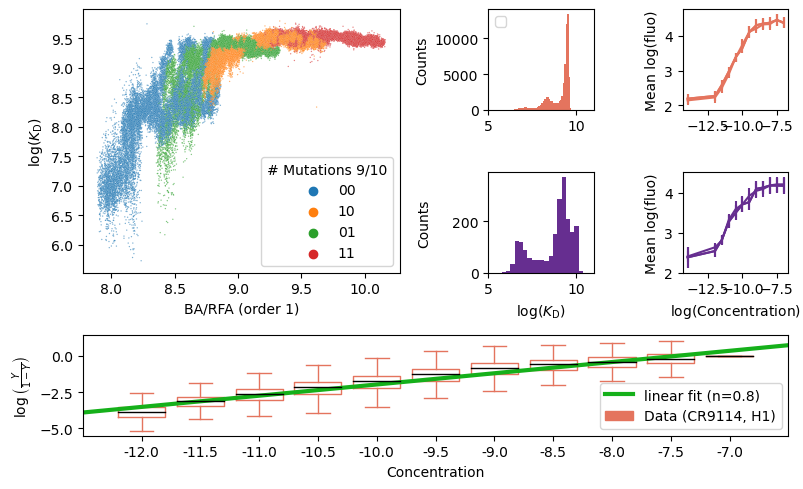

In [10]:
# "global epistasis" figure
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import gridspec

concentrations = [-7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5, -12, -14]
concentrations = {str(ii+1): c for ii, c in enumerate(concentrations)}

fig = plt.figure(figsize=(8, 5))
# Create grid
gs = gridspec.GridSpec(3, 3, width_ratios=[3, 1, 1])

# Create subplots
ax1 = plt.subplot(gs[:2, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[0, 2])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[2, :])


# Create a transparent colormap
colors = [(1, 1, 1), '#e4745e']  # White to your color
n_bins = 100  # Number of bins
cmap_name = "custom"
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)  # setting alpha
my_cmap = ListedColormap(my_cmap)

#fig, ax = plt.subplots()
ax1.set_facecolor('none')
fig.set_facecolor('none')

mutations = []
for ii, g in enumerate(geno_h1):
    mutations += ["".join([str(int(a)) for a in g[[10, 9]]])]

dfplot = pd.DataFrame()
dfplot['Binding affinity'] = measured_phenotypes_h1
dfplot['BA/RFA model (order 1)'] = geno_h1@res_h1
dfplot['# Mutations 9/10'] = mutations
#dfplot['# Mutations 9/10'] = dfplot['# Mutations 9/10']

sns.scatterplot(data=dfplot, x='BA/RFA model (order 1)', y='Binding affinity', hue='# Mutations 9/10', 
                ax=ax1, alpha=0.6, s=1)#,
                # cmap=my_cmap, bins='log')
#ax1.legend().remove()
sns.distplot(x=measured_phenotypes_h1, ax=ax2, kde=False, hist_kws={'color': '#e4745e', 'alpha': 1})
sns.distplot(x=measured_phenotypes_h9, ax=ax3, kde=False,  hist_kws={'color': "#662e90", 'alpha': 1})
ax2.legend(loc='upper left')
ax2.set_xlim((5, 11))
ax3.set_xlim((5, 11))


ax1.set_ylabel(r'$\log(K_\mathrm{D})$')
ax1.set_xlabel('BA/RFA (order 1)')
ax3.set_xlabel(r'$\log(K_\mathrm{D})$')
ax3.set_ylabel('Counts', labelpad=15)
ax2.set_ylabel('Counts')

#ax2.yaxis.tick_right()
#ax3.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax3.yaxis.set_label_position("right")


val = dfh1[dfh1.logKd_x > 9.5].iloc[42]
ax4.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo_x'], yerr=val['err_fluo_x'], c='#e4745e')
ax4.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo'], yerr=val['err_fluo'], c='#e4745e')
ax4.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo_y'], yerr=val['err_fluo_y'], c='#e4745e')

val = dfh9[dfh9.logKd_x > 10].iloc[42]
ax5.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo_x'], yerr=val['err_fluo_x'], c="#662e90")
ax5.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo'], yerr=val['err_fluo'], c="#662e90")
ax5.errorbar(x=[concentrations[str(a)] for a in range(1, 13)], y=val['fluo_y'], yerr=val['err_fluo_y'], c="#662e90")

ax4.set_ylabel('Mean log(fluo)')
ax5.set_ylabel('Mean log(fluo)')
ax5.set_xlabel(r'$\log(\mathrm{Concentration})$')


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


dctplot = []
for ii in concentrations:
    for val in dfh1[f'corr_val{ii}_x']:
        dctplot += [{'concentration': concentrations[ii], 'Y': val}]
dfplot = pd.DataFrame(dctplot)

dfplot['concentration'] = dfplot.concentration.astype('float')

color = '#e4745e'

props = {'boxprops': {'color': color},
         'whiskerprops': {'color': color},
         'capprops': {'color': color},
         'medianprops': {'color': 'black'}}


#fig, ax = plt.subplots(figsize=(6, 2))
concs = [a for a in dfplot.concentration.unique() if a > -13]
data = [dfplot[dfplot.concentration == c]['Y'].dropna().to_list() for c in concs]
ax6.boxplot(data, positions=concs, showfliers=False, widths=0.4,  **props)

#fit 
dffit = dfplot[dfplot.concentration > -13].groupby('concentration').Y.mean().to_frame().reset_index()
print(dffit)
# Find best fit
m, b = np.polyfit(dffit['concentration'], dffit['Y'], 1)
print(f"Best fit line: y = {m}x + {b}")
xs = np.linspace(-14, -6, 100)



ax6.plot(xs, m*xs + b, color="xkcd:green", lw=3, label="linear fit (n=0.8)")
ax6.set_xlim((-12.5, -6.5))
ax6.set_xlabel('Concentration')
ax6.set_ylabel(r'$\log\left(\frac{Y}{1-Y}\right)$')


# Existing handles and labels
handles, labels = ax6.get_legend_handles_labels()
# Create a custom patch for the legend
patch = mpatches.Patch(color='#e4745e', label='My Label')
handles.append(patch)
labels.append('Data (CR9114, H1)')
ax6.legend(handles=handles, labels=labels)


plt.tight_layout() 
plt.savefig('kd_comp_h1_h9.png', dpi=600)
plt.show()